# Importing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Conv1D, Flatten, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

2022-12-02 15:03:27.964159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 15:03:29.366382: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 15:03:29.366437: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-02 15:03:33.390394: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

# Loading data

## loading train data

In [2]:
# loading feature data 
data_features=pd.read_csv('../raw_data/dengue_features_train.csv')
# loading outcome data
data_outcome=pd.read_csv('../raw_data/dengue_labels_train.csv')
# merging two data sets
data=data_features.merge(data_outcome)

## splitting train data 

In [4]:
sj_data = data[data['city'] == 'sj']
sj_data = sj_data.drop('city', axis=1)

iq_data = data[data['city'] == 'iq']
iq_data = iq_data.drop('city', axis=1)

## Loading test data

In [129]:
testing_data = pd.read_csv('../raw_data/dengue_features_test.csv')
# splitting test data according to city
sj_test = testing_data[testing_data.city=='sj'].copy()
iq_test = testing_data[testing_data.city=='iq'].copy()

# Preprocessing data

In [6]:
def preprocess(rawfeats,train=True):
    
    #reset index to prevent issues when merging
    reindexed_data = rawfeats.reset_index(drop = True)
    
    #fill nas with interpolation
    feats = reindexed_data.interpolate(method='linear')
    
    new_columns = pd.DataFrame()
    #scale and average total precipitation
    precipitation_to_avg = feats.loc[:,['reanalysis_sat_precip_amt_mm','precipitation_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2']]
    scaled_precip = pd.DataFrame(MinMaxScaler().fit_transform(precipitation_to_avg), 
                                columns=precipitation_to_avg.columns)
    new_columns.loc[:,'avg_total_precipitation'] = scaled_precip.mean(axis=1)
    
    #scale and average temperature
    temps_to_avg = feats.loc[:,['reanalysis_air_temp_k','reanalysis_avg_temp_k','station_avg_temp_c']]
    scaled_temps = pd.DataFrame(MinMaxScaler().fit_transform(temps_to_avg), 
                                columns=temps_to_avg.columns)
    new_columns.loc[:,'avg_temp'] = scaled_temps.mean(axis=1)
    
    #scale and average max temperature
    max_temps_to_avg = feats.loc[:,['station_max_temp_c','reanalysis_max_air_temp_k']]
    scaled_max_temps = pd.DataFrame(MinMaxScaler().fit_transform(max_temps_to_avg), 
                                columns=max_temps_to_avg.columns)
    new_columns.loc[:,'avg_max_temp'] = scaled_max_temps.mean(axis=1)
    
    #scale and average min temperature
    min_temps_to_avg = feats.loc[:,['station_min_temp_c','reanalysis_min_air_temp_k']]
    scaled_min_temps = pd.DataFrame(MinMaxScaler().fit_transform(min_temps_to_avg), 
                                columns=min_temps_to_avg.columns)
    new_columns.loc[:,'avg_min_temp'] = scaled_min_temps.mean(axis=1)
    
    #scale and average diurnal temperature
    diurnal_temps_to_avg = feats.loc[:,['station_diur_temp_rng_c','reanalysis_tdtr_k']]
    scaled_diurnal_temps = pd.DataFrame(MinMaxScaler().fit_transform(diurnal_temps_to_avg), 
                                columns=diurnal_temps_to_avg.columns)
    new_columns.loc[:,'avg_diurnal_temp'] = scaled_diurnal_temps.mean(axis=1)
    
    #scale humidity and dew point data
    remaining_feats_to_scale = feats.loc[:,['reanalysis_specific_humidity_g_per_kg','reanalysis_relative_humidity_percent','reanalysis_dew_point_temp_k']]
    scaled_feats = pd.DataFrame(MinMaxScaler().fit_transform(remaining_feats_to_scale), 
                                columns=remaining_feats_to_scale.columns)
    
    df = new_columns.join(scaled_feats)

    #merge back together
    non_scaled_feats = feats[['ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'total_cases']]
    
    final_df = df.join(non_scaled_feats)
    
    return final_df

In [189]:
iq_data = preprocess(iq_data)
sj_data = preprocess(sj_data)

In [8]:
# splitting train data into X and y
sj_X = sj_data.drop(['total_cases'], axis=1)
sj_y = sj_data['total_cases']
iq_X = iq_data.drop(['total_cases'], axis=1)
iq_y = iq_data['total_cases']

In [9]:
# splitting train data into train and test sets for sj
sj_X_train = sj_X.head(702)
sj_X_test = sj_X.tail(234)
sj_y_train = sj_y.head(702)
sj_y_test = sj_y.tail(234)
print(sj_X_train.shape)
print(sj_y_test.shape)

(702, 12)
(234,)


In [10]:
# splitting train data into train and test sets for iq
iq_X_train = iq_X.head(490)
iq_X_test = iq_X.tail(130)
iq_y_train = iq_y.head(490)
iq_y_test = iq_y.tail(130)
print(iq_X_train.shape)
print(iq_y_train.shape)

(490, 12)
(490,)


# Transforming data into sequences

## For train data

### For San Juan

In [19]:
# Create training sequences for sj
sj_train_sequences = TimeseriesGenerator(sj_X_train, 
                                      sj_y_train.values, 
                                      length=7, 
                                      batch_size=1)

# Create test sequences
sj_test_sequences = TimeseriesGenerator(sj_X_test, 
                                     sj_y_test.values, 
                                     length=7, 
                                     batch_size=1)

# Create full sequences for sj
sj_full_sequences = TimeseriesGenerator(sj_X, 
                                      sj_y.values, 
                                      length=7, 
                                      batch_size=1)

### For Iquitos

In [20]:
# Create training sequences for iq
iq_train_sequences = TimeseriesGenerator(iq_X_train, 
                                      iq_y_train.values, 
                                      length=7, 
                                      batch_size=1)

# Create test sequences
iq_test_sequences = TimeseriesGenerator(iq_X_test, 
                                     iq_y_test.values, 
                                     length=7, 
                                     batch_size=1)
# Create full sequences for iq
iq_full_sequences = TimeseriesGenerator(iq_X, 
                                      iq_y.values, 
                                      length=7, 
                                      batch_size=1)

## For test data

In [30]:
def preprocess2(rawfeats,train=True):
    
    #reset index to prevent issues when merging
    reindexed_data = rawfeats.reset_index(drop = True)
    
    #fill nas with interpolation
    feats = reindexed_data.interpolate(method='linear')
    
    new_columns = pd.DataFrame()
    #scale and average total precipitation
    precipitation_to_avg = feats.loc[:,['reanalysis_sat_precip_amt_mm','precipitation_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2']]
    scaled_precip = pd.DataFrame(MinMaxScaler().fit_transform(precipitation_to_avg), 
                                columns=precipitation_to_avg.columns)
    new_columns.loc[:,'avg_total_precipitation'] = scaled_precip.mean(axis=1)
    
    #scale and average temperature
    temps_to_avg = feats.loc[:,['reanalysis_air_temp_k','reanalysis_avg_temp_k','station_avg_temp_c']]
    scaled_temps = pd.DataFrame(MinMaxScaler().fit_transform(temps_to_avg), 
                                columns=temps_to_avg.columns)
    new_columns.loc[:,'avg_temp'] = scaled_temps.mean(axis=1)
    
    #scale and average max temperature
    max_temps_to_avg = feats.loc[:,['station_max_temp_c','reanalysis_max_air_temp_k']]
    scaled_max_temps = pd.DataFrame(MinMaxScaler().fit_transform(max_temps_to_avg), 
                                columns=max_temps_to_avg.columns)
    new_columns.loc[:,'avg_max_temp'] = scaled_max_temps.mean(axis=1)
    
    #scale and average min temperature
    min_temps_to_avg = feats.loc[:,['station_min_temp_c','reanalysis_min_air_temp_k']]
    scaled_min_temps = pd.DataFrame(MinMaxScaler().fit_transform(min_temps_to_avg), 
                                columns=min_temps_to_avg.columns)
    new_columns.loc[:,'avg_min_temp'] = scaled_min_temps.mean(axis=1)
    
    #scale and average diurnal temperature
    diurnal_temps_to_avg = feats.loc[:,['station_diur_temp_rng_c','reanalysis_tdtr_k']]
    scaled_diurnal_temps = pd.DataFrame(MinMaxScaler().fit_transform(diurnal_temps_to_avg), 
                                columns=diurnal_temps_to_avg.columns)
    new_columns.loc[:,'avg_diurnal_temp'] = scaled_diurnal_temps.mean(axis=1)
    
    #scale humidity and dew point data
    remaining_feats_to_scale = feats.loc[:,['reanalysis_specific_humidity_g_per_kg','reanalysis_relative_humidity_percent','reanalysis_dew_point_temp_k']]
    scaled_feats = pd.DataFrame(MinMaxScaler().fit_transform(remaining_feats_to_scale), 
                                columns=remaining_feats_to_scale.columns)
    
    df = new_columns.join(scaled_feats)

    #merge back together
    non_scaled_feats = feats[['ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw']]
    
    final_df = df.join(non_scaled_feats)
    
    return final_df

In [133]:
sj_test = preprocess2(sj_test,train=False)
iq_test = preprocess2(iq_test,train=False)

In [134]:
# Create test sequences for sj
sj_actual_test_sequences = TimeseriesGenerator(sj_test, 
                                      sj_test.values, 
                                      length=7, 
                                      batch_size=1)
# Create test sequences for iq
iq_actual_test_sequences = TimeseriesGenerator(iq_test,
                                        iq_test.values,
                                      length=7, 
                                      batch_size=1)

# RNN model

## RNN model design

In [62]:
def rnn_model():
    # Design RNN
    rnn_model = Sequential()
    # RNN Layers
    rnn_model.add(GRU(20, input_shape=(7, 12), 
              return_sequences=True)) 
    rnn_model.add(GRU(20, return_sequences=False))
    rnn_model.add(Dropout(0.25))
    # Hidden dense layer
    rnn_model.add(Dense(10, activation='relu'))
    rnn_model.add(Dropout(0.25))
    # Output layer
    rnn_model.add(Dense(1, activation='linear'))
    # Compile model
    rnn_model.compile(loss='mae', optimizer='adam',metrics = ['mae'])
    return rnn_model

## RNN model fit

In [68]:
# model fit for sj
sj_model_rnn = rnn_model()
sj_rnn_hist=sj_model_rnn.fit(sj_train_sequences,epochs=40, verbose=1)

Epoch 1/40
695/695 [==============================] - 22s 21ms/step - loss: 33.1162 - mae: 33.1162
Epoch 2/40
695/695 [==============================] - 11s 16ms/step - loss: 28.9066 - mae: 28.9066
Epoch 3/40
695/695 [==============================] - 12s 17ms/step - loss: 28.6457 - mae: 28.6457
Epoch 4/40
695/695 [==============================] - 12s 18ms/step - loss: 28.3217 - mae: 28.3217
Epoch 5/40
695/695 [==============================] - 11s 16ms/step - loss: 26.9494 - mae: 26.9494
Epoch 6/40
695/695 [==============================] - 12s 17ms/step - loss: 26.8304 - mae: 26.8304
Epoch 7/40
695/695 [==============================] - 13s 18ms/step - loss: 26.3150 - mae: 26.3150
Epoch 8/40
695/695 [==============================] - 12s 18ms/step - loss: 26.3591 - mae: 26.3591
Epoch 9/40
695/695 [==============================] - 14s 20ms/step - loss: 26.6111 - mae: 26.6111
Epoch 10/40
695/695 [==============================] - 14s 21ms/step - loss: 25.9310 - mae: 25.9310
Epoch 11/

In [17]:
# model fit for iq
iq_model_rnn = rnn_model()
iq_rnn_hist=iq_model_rnn.fit_generator(iq_train_sequences,epochs=40, verbose=1)

Epoch 1/40


/tmp/ipykernel_5826/3353771620.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  iq_rnn_hist=iq_model_rnn.fit_generator(iq_train_sequences,epochs=40, verbose=1)


483/483 [==============================] - 31s 27ms/step - loss: 6.4411 - mae: 6.4411
Epoch 2/40
483/483 [==============================] - 13s 26ms/step - loss: 6.1843 - mae: 6.1843
Epoch 3/40
483/483 [==============================] - 14s 29ms/step - loss: 6.2832 - mae: 6.2832
Epoch 4/40
483/483 [==============================] - 11s 22ms/step - loss: 6.1965 - mae: 6.1965
Epoch 5/40
483/483 [==============================] - 11s 22ms/step - loss: 6.1028 - mae: 6.1028
Epoch 6/40
483/483 [==============================] - 13s 27ms/step - loss: 6.1222 - mae: 6.1222
Epoch 7/40
483/483 [==============================] - 14s 28ms/step - loss: 6.0711 - mae: 6.0711
Epoch 8/40
483/483 [==============================] - 16s 33ms/step - loss: 6.0931 - mae: 6.0931
Epoch 9/40
483/483 [==============================] - 12s 24ms/step - loss: 5.9733 - mae: 5.9733
Epoch 10/40
483/483 [==============================] - 10s 21ms/step - loss: 6.0129 - mae: 6.0129
Epoch 11/40
483/483 [===================

## Evaluation of RNN models

In [69]:
sj_rnn_model_evaluate= sj_model_rnn.evaluate(sj_test_sequences)
iq_rnn_model_evaluate= iq_model_rnn.evaluate(iq_test_sequences)

123/123 [==============================] - 1s 6ms/step - loss: 6.4227 - mae: 6.4227


In [70]:
# Get predictions for RNN sj
sj_rnn_train_preds = sj_model_rnn.predict(sj_full_sequences)
sj_rnn_test_preds = sj_model_rnn.predict(sj_actual_test_sequences)

253/253 [==============================] - 2s 5ms/step


In [71]:
# Get predictions for RNN iq
iq_rnn_train_preds = iq_model_rnn.predict(iq_full_sequences)
iq_rnn_test_preds = iq_model_rnn.predict(iq_actual_test_sequences)

149/149 [==============================] - 1s 5ms/step


## Plotting RNN model predictions

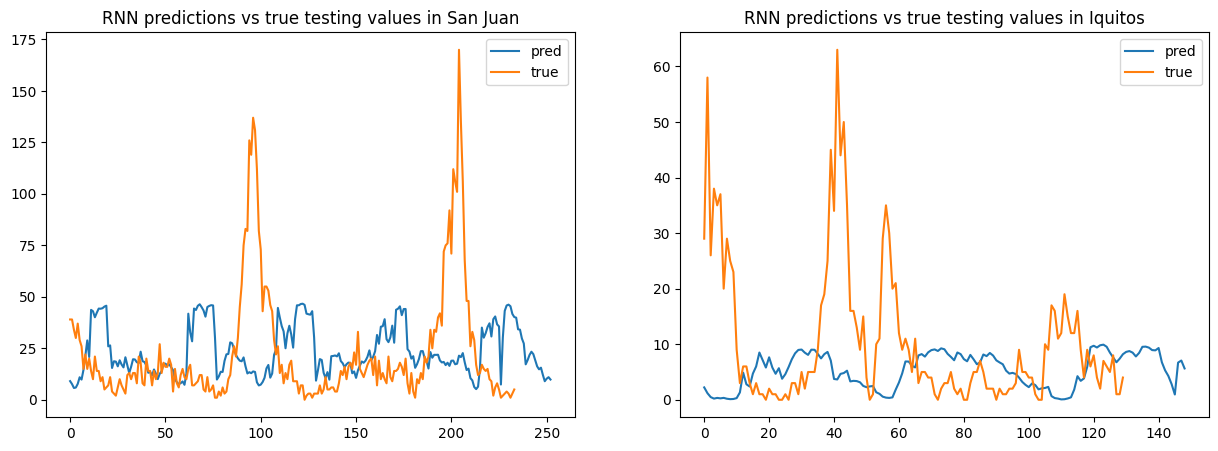

In [171]:
#Plotting true values vs predictions on testing data
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(sj_rnn_test_preds, label='pred')
plt.plot(sj_y_test.values, label='true')
plt.legend()
plt.title('RNN predictions vs true testing values in San Juan')
plt.show;
plt.subplot(122)
plt.plot(iq_rnn_test_preds, label='pred')
plt.plot(iq_y_test.values, label='true')
plt.legend()
plt.title('RNN predictions vs true testing values in Iquitos')
plt.show;

## RNN model statistics

In [184]:
rnn_statistics=[["San Juan", 13.54, 26.56], 
        ["Iquitos", 6.42, 26.56]]
col_names = ["City", "test_mae", "combined_test_mae"]
print(tabulate(rnn_statistics, headers=col_names, tablefmt="grid", showindex="always"))

+----+----------+------------+---------------------+
|    | City     |   test_mae |   combined_test_mae |
+====+==========+============+=====================+
|  0 | San Juan |      13.54 |               26.56 |
+----+----------+------------+---------------------+
|  1 | Iquitos  |       6.42 |               26.56 |
+----+----------+------------+---------------------+


# LSTM model

## LSTM model design

In [38]:
def lstm_model():
    model_lstm = Sequential()
    # LSTM Layer 
    model_lstm.add(LSTM(units=60, return_sequences=True, input_shape=(7,12)))
    model_lstm.add(Dropout(0.25))
    # Hidden dense layer
    model_lstm.add(Dense(40, activation='relu'))
    model_lstm.add(Dropout(0.25))
    # Hidden dense layer
    model_lstm.add(Dense(20, activation='relu'))
    model_lstm.add(Dropout(0.25))
    # Hidden dense layer
    model_lstm.add(Dense(8, activation='relu'))
    model_lstm.add(Dropout(0.25))
    # Hidden dense layer
    model_lstm.add(Dense(4, activation='relu'))
    model_lstm.add(Dropout(0.25))
    # Output layer
    model_lstm.add(Dense(1, activation='linear'))

    # compile model
    model_lstm.compile(loss='mae', optimizer='rmsprop', metrics = ['mae'])
    
    return model_lstm

## LSTM model fit for both cities

In [40]:
sj_model_lstm = lstm_model()
sj_model_lstm.fit_generator(sj_train_sequences,epochs=40, verbose=1)

Epoch 1/40


/tmp/ipykernel_5826/2170332389.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  sj_model_lstm.fit_generator(sj_train_sequences,epochs=40, verbose=1)


695/695 [==============================] - 16s 15ms/step - loss: 31.1846 - mae: 31.1846
Epoch 2/40
695/695 [==============================] - 10s 14ms/step - loss: 29.4071 - mae: 29.4070
Epoch 3/40
695/695 [==============================] - 10s 14ms/step - loss: 28.7077 - mae: 28.7076
Epoch 4/40
695/695 [==============================] - 12s 17ms/step - loss: 28.1241 - mae: 28.1241
Epoch 5/40
695/695 [==============================] - 12s 17ms/step - loss: 28.1893 - mae: 28.1893
Epoch 6/40
695/695 [==============================] - 11s 16ms/step - loss: 28.1130 - mae: 28.1130
Epoch 7/40
695/695 [==============================] - 16s 23ms/step - loss: 27.5258 - mae: 27.5258
Epoch 8/40
695/695 [==============================] - 11s 15ms/step - loss: 27.5080 - mae: 27.5080
Epoch 9/40
695/695 [==============================] - 11s 16ms/step - loss: 27.2896 - mae: 27.2896
Epoch 10/40
695/695 [==============================] - 14s 20ms/step - loss: 27.0266 - mae: 27.0266
Epoch 11/40
695/695 

In [ ]:
iq_model_lstm = lstm_model()
iq_model_lstm.fit_generator(iq_full_sequences ,epochs=40, verbose=1)

## Evaluation of LSTM models

In [79]:
sj_lstm_model_evaluate= sj_model_lstm.evaluate(sj_test_sequences)
iq_lstm_model_evaluate= iq_model_lstm.evaluate(iq_test_sequences)

123/123 [==============================] - 2s 5ms/step - loss: 6.9356 - mae: 6.9356


In [113]:
# Get predictions of LSTM model for sj
sj_lstm_train_preds = sj_model_lstm.predict(sj_train_sequences)
sj_lstm_test_preds = sj_model_lstm.predict(sj_test_sequences)

227/227 [==============================] - 1s 5ms/step


In [115]:
# Get predictions of LSTM model for iq
iq_lstm_train_preds = iq_model_lstm.predict(iq_train_sequences)
iq_lstm_test_preds = iq_model_lstm.predict(iq_test_sequences)

123/123 [==============================] - 1s 5ms/step


## Plotting LSTM model predicitions

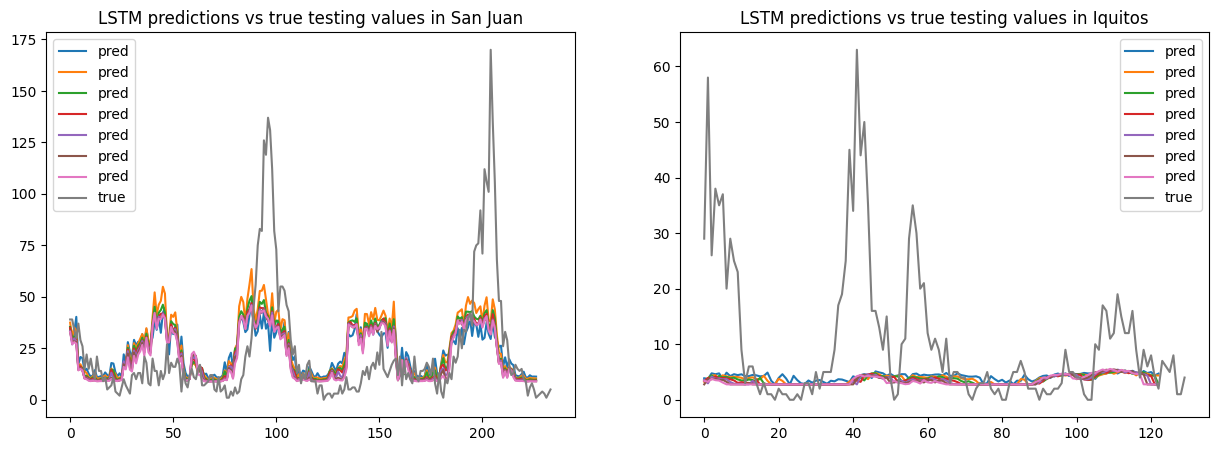

In [174]:
#Plotting true values vs predictions on testing data
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(sj_lstm_test_preds, label='pred')
plt.plot(sj_y_test.values, label='true')
plt.legend()
plt.title('LSTM predictions vs true testing values in San Juan')
plt.show;
plt.subplot(122)
plt.plot(iq_lstm_test_preds, label='pred')
plt.plot(iq_y_test.values, label='true')
plt.legend()
plt.title('LSTM predictions vs true testing values in Iquitos')
plt.show;

## LSTM model statistics

In [185]:
lstm_statistics=[["San Juan", 14.46, 26.23], 
        ["Iquitos", 6.94, 26.23]]
col_names = ["City", "test_mae", "combined_test_mae"]
print(tabulate(lstm_statistics, headers=col_names, tablefmt="grid", showindex="always"))

+----+----------+------------+---------------------+
|    | City     |   test_mae |   combined_test_mae |
+====+==========+============+=====================+
|  0 | San Juan |      14.46 |               26.23 |
+----+----------+------------+---------------------+
|  1 | Iquitos  |       6.94 |               26.23 |
+----+----------+------------+---------------------+


# CNN model

### additional preprocess for cnn model

In [53]:
# Expand dimensions for CNN for sj
sj_X_train_cnn = np.expand_dims(sj_X_train, axis=2)
sj_X_test_cnn = np.expand_dims(sj_X_test, axis=2)
sj_X_train_full_cnn = np.expand_dims(sj_X, axis=2)

# Expand dimensions for CNN for iq
iq_X_train_cnn = np.expand_dims(iq_X_train, axis=2)
iq_X_test_cnn = np.expand_dims(iq_X_test, axis=2)
iq_X_train_full_cnn = np.expand_dims(iq_X, axis=2)

## CNN model design

In [105]:
# Function to gridsearch cnn
def cnn_function():
    # Design CNN
    cnn_model = Sequential()
    # CNN Layers 
    cnn_model.add(Conv1D(filters=12,
                         kernel_size=2,activation = 'relu',   
                     input_shape = (7,12))) 
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Flatten())
    cnn_model.add(Dropout(0.25))
    # Hidden dense layer
    cnn_model.add(Dense(8, activation='relu'))
    cnn_model.add(Dropout(0.25))
    # Output layer
    cnn_model.add(Dense(1, activation='linear'))
    # Compile Model
    cnn_model.compile(loss='mae', optimizer='adam', metrics = ['mae'])
    # return model
    return cnn_model

## CNN model fit for both cities

In [106]:
sj_model_cnn = cnn_function()
sj_model_cnn.fit_generator(sj_train_sequences,epochs=40, verbose=1)

Epoch 1/40


/tmp/ipykernel_5826/1630234296.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  sj_model_cnn.fit_generator(sj_train_sequences,epochs=40, verbose=1)


695/695 [==============================] - 5s 5ms/step - loss: 32.0960 - mae: 32.0960
Epoch 2/40
695/695 [==============================] - 3s 4ms/step - loss: 28.8291 - mae: 28.8291
Epoch 3/40
695/695 [==============================] - 3s 5ms/step - loss: 27.5763 - mae: 27.5763
Epoch 4/40
695/695 [==============================] - 3s 4ms/step - loss: 27.9944 - mae: 27.9944
Epoch 5/40
695/695 [==============================] - 3s 4ms/step - loss: 28.0635 - mae: 28.0635
Epoch 6/40
695/695 [==============================] - 3s 4ms/step - loss: 28.0723 - mae: 28.0723
Epoch 7/40
695/695 [==============================] - 3s 4ms/step - loss: 27.9736 - mae: 27.9736
Epoch 8/40
695/695 [==============================] - 3s 5ms/step - loss: 27.5315 - mae: 27.5315
Epoch 9/40
695/695 [==============================] - 3s 4ms/step - loss: 27.4125 - mae: 27.4125
Epoch 10/40
695/695 [==============================] - 6s 8ms/step - loss: 26.6785 - mae: 26.6785
Epoch 11/40
695/695 [===================

In [109]:
iq_model_cnn = cnn_function()
iq_model_cnn.fit_generator(iq_train_sequences,epochs=40, verbose=1)

Epoch 1/40


/tmp/ipykernel_5826/3236789135.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  iq_model_cnn.fit_generator(iq_train_sequences,epochs=40, verbose=1)


483/483 [==============================] - 8s 6ms/step - loss: 6.8883 - mae: 6.8883
Epoch 2/40
483/483 [==============================] - 4s 7ms/step - loss: 6.3098 - mae: 6.3098
Epoch 3/40
483/483 [==============================] - 4s 8ms/step - loss: 6.3583 - mae: 6.3583
Epoch 4/40
483/483 [==============================] - 4s 8ms/step - loss: 6.3081 - mae: 6.3081
Epoch 5/40
483/483 [==============================] - 3s 6ms/step - loss: 6.0635 - mae: 6.0635
Epoch 6/40
483/483 [==============================] - 5s 10ms/step - loss: 6.1591 - mae: 6.1591
Epoch 7/40
483/483 [==============================] - 4s 7ms/step - loss: 6.2098 - mae: 6.2098
Epoch 8/40
483/483 [==============================] - 3s 7ms/step - loss: 6.1703 - mae: 6.1703
Epoch 9/40
483/483 [==============================] - 3s 5ms/step - loss: 6.1801 - mae: 6.1801
Epoch 10/40
483/483 [==============================] - 2s 4ms/step - loss: 6.2048 - mae: 6.2048
Epoch 11/40
483/483 [==============================] - 2s 5

## Evaluation of CNN models

In [110]:
sj_cnn_model_evaluate= sj_model_cnn.evaluate(sj_test_sequences)
iq_cnn_model_evaluate= iq_model_cnn.evaluate(iq_test_sequences)

123/123 [==============================] - 1s 4ms/step - loss: 6.8937 - mae: 6.8937


In [111]:
# Get CNN model predictions for sj
sj_cnn_train_preds = sj_model_cnn.predict(sj_train_sequences)
sj_cnn_test_preds = sj_model_cnn.predict(sj_test_sequences)

227/227 [==============================] - 1s 3ms/step


In [117]:
# Get CNN model predictions for iq
iq_cnn_train_preds = iq_model_cnn.predict(iq_train_sequences)
iq_cnn_test_preds = iq_model_cnn.predict(iq_test_sequences)

123/123 [==============================] - 1s 7ms/step


## Plotting CNN model predicitions

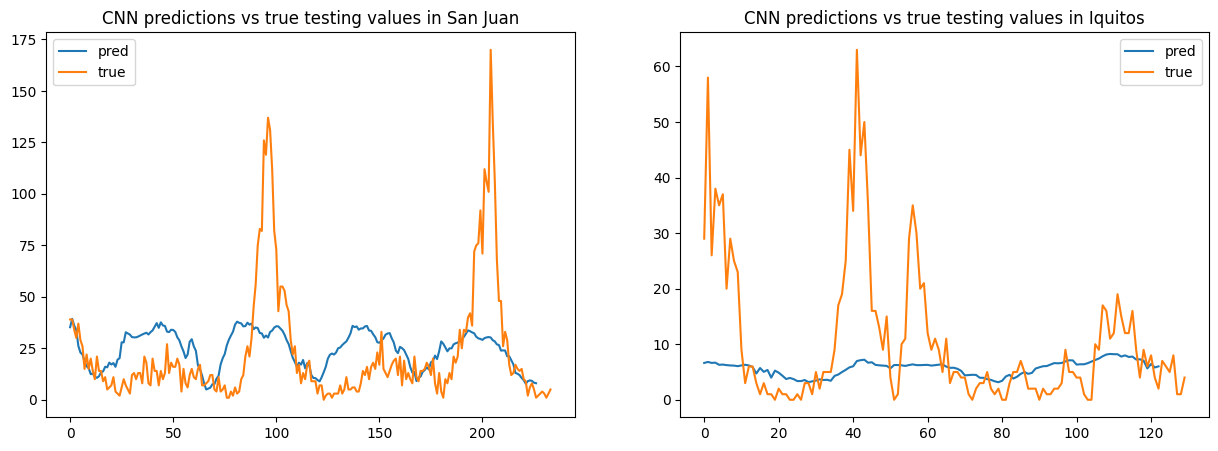

In [175]:
#Plotting true values vs predictions on testing data
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(sj_cnn_test_preds, label='pred')
plt.plot(sj_y_test.values, label='true')
plt.legend()
plt.title('CNN predictions vs true testing values in San Juan')
plt.show;
plt.subplot(122)
plt.plot(iq_cnn_test_preds, label='pred')
plt.plot(iq_y_test.values, label='true')
plt.legend()
plt.title('CNN predictions vs true testing values in Iquitos')
plt.show;

## CNN model statistics

In [182]:
cnn_statistics=[["San Juan", 17.56, 25.95], 
        ["Iquitos", 6.89, 25.95 ]]
col_names = ["City", "test_mae", "combined_test_mae"]
print(tabulate(cnn_statistics, headers=col_names, tablefmt="grid", showindex="always"))

+----+----------+------------+---------------------+
|    | City     |   test_mae |   combined_test_mae |
+====+==========+============+=====================+
|  0 | San Juan |      17.56 |               25.95 |
+----+----------+------------+---------------------+
|  1 | Iquitos  |       6.89 |               25.95 |
+----+----------+------------+---------------------+


# Models summary

In [187]:
model_statistics=[25.56, 26.23, 25.95], 
        
col_names = ["RNN model score", "LSTM model score", "CNN model score"]
print(tabulate(model_statistics, headers=col_names, tablefmt="grid", showindex="always"))

+----+-------------------+--------------------+-------------------+
|    |   RNN model score |   LSTM model score |   CNN model score |
+====+===================+====================+===================+
|  0 |             25.56 |              26.23 |             25.95 |
+----+-------------------+--------------------+-------------------+


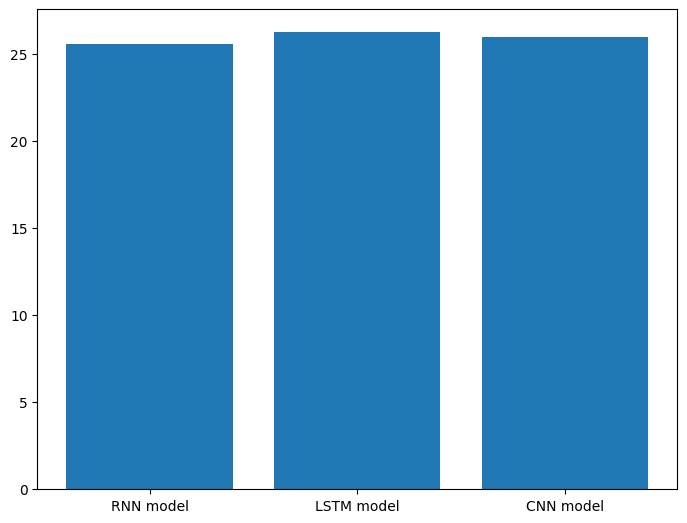

In [188]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['RNN model', 'LSTM model', 'CNN model']
students = [25.5601,26.2260,25.9543]
ax.bar(langs,students)
plt.show()